In [1]:
from sklearn.datasets import load_boston

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Loading and Examining Initial Dataset

In [3]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


In [4]:
boston.target.shape

(506,)

In [5]:
boston.DESCR

".. _boston_dataset:\n\nBoston house prices dataset\n---------------------------\n\n**Data Set Characteristics:**  \n\n    :Number of Instances: 506 \n\n    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.\n\n    :Attribute Information (in order):\n        - CRIM     per capita crime rate by town\n        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.\n        - INDUS    proportion of non-retail business acres per town\n        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n        - NOX      nitric oxides concentration (parts per 10 million)\n        - RM       average number of rooms per dwelling\n        - AGE      proportion of owner-occupied units built prior to 1940\n        - DIS      weighted distances to five Boston employment centres\n        - RAD      index of accessibility to radial highways\n        - TAX      full-value property-tax rate per $10,000

### Step 1: Setting up Initial Regression

In [6]:
x = boston.data[:,np.r_[0:11,12]]
y = boston.target

In [8]:
def regTesting(x,y):
    regr = LinearRegression()
    regr.fit(x,y)
    y_pred = regr.predict(x)
    mse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    return mse, r2

In [9]:
base_mse, base_r2 = regTesting(x,y)
print('Baseline MSE:', base_mse,'\nBaseline R2:', base_r2)

Baseline MSE: 22.429681439489926 
Baseline R2: 0.7343070437613076


### Step 2: MCAR Imputation Performance

In [11]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [12]:
perc_array = [0.01, 0.05, 0.10, 0.2, 0.33, 0.5]

In [13]:
def mcar_dataset(x, rate, random = 0):
    rng = np.random.RandomState(random)
    missing_rate = rate
    length = len(x)
    num_to_remove = int(np.floor(length * missing_rate))
    missing_records_bool = np.hstack((np.zeros(length - num_to_remove,
                                          dtype=np.bool),
                                 np.ones(num_to_remove,
                                         dtype=np.bool)))
    rng.shuffle(missing_records_bool)
    
    X_missing = x.copy()

    # change the [0] index to represent the column to be reduced
    X_missing[np.where(missing_records_bool)[0]] = np.nan
    return X_missing

In [15]:
# The sample_posterior = True is to allow for multiple imputation, if we're doing that. Would need to modify the random_state for each iteration (maybe just remove the random_state?)
imputer = IterativeImputer(missing_values=np.nan, sample_posterior=True, random_state=0)

In [26]:
imputed_scores = []
for rate in perc_array:
    x_new = mcar_dataset(x,rate)
    x_impute = imputer.fit_transform(x_new)
    mse, r2 = regTesting(x_impute,y)
    imputed_scores.append((rate, mse,r2))

In [27]:
imputed_scores

[(0.01, 22.64428223592788, 0.7317649693154178),
 (0.05, 26.275952472138783, 0.6887456690303894),
 (0.1, 34.14565882189338, 0.5955243029384305),
 (0.2, 41.45609482792811, 0.5089278276796485),
 (0.33, 54.40798916616807, 0.35550491327483247),
 (0.5, 68.3520295315182, 0.19032943735127505)]

In [33]:
dt=np.dtype('float,float,float')
imp_scores_arr = np.array(imputed_scores,dtype=dt)
imp_scores_arr.dtype.names=['Missing Rate','MSE','R2']
imp_scores_arr

array([(0.01, 22.64428224, 0.73176497), (0.05, 26.27595247, 0.68874567),
       (0.1 , 34.14565882, 0.5955243 ), (0.2 , 41.45609483, 0.50892783),
       (0.33, 54.40798917, 0.35550491), (0.5 , 68.35202953, 0.19032944)],
      dtype=[('Missing Rate', '<f8'), ('MSE', '<f8'), ('R2', '<f8')])

In [38]:
import matplotlib.pyplot as plt

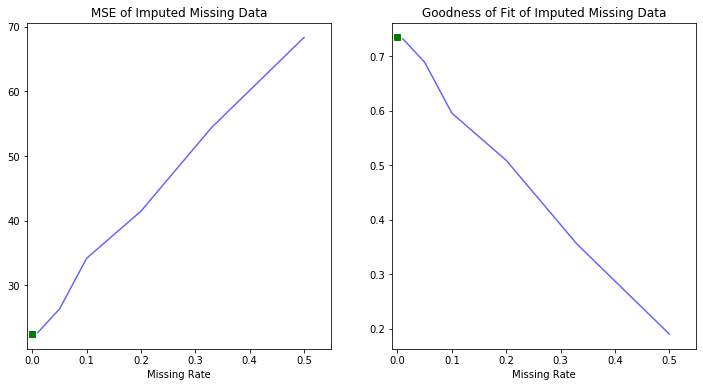

In [61]:
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.plot(imp_scores_arr['Missing Rate'], imp_scores_arr['MSE'], alpha=0.6, c='blue')
ax1.plot(0, base_mse, 'gs')
ax1.set_title('MSE of Imputed Missing Data')
ax1.set_xlim(left=imp_scores_arr['Missing Rate'][0]*-1, right=imp_scores_arr['Missing Rate'][5]* 1.1)
ax1.set_xlabel('Missing Rate')

ax2 = plt.subplot(122)
ax2.plot(imp_scores_arr['Missing Rate'], imp_scores_arr['R2'], alpha=0.6, c='blue')
ax2.plot(0,base_r2, 'gs')
ax2.set_title('Goodness of Fit of Imputed Missing Data')
ax2.set_xlim(left=imp_scores_arr['Missing Rate'][0]*-1, right=imp_scores_arr['Missing Rate'][5]* 1.1)
ax2.set_xlabel('Missing Rate')

plt.show()

### Step 3: MAR Imputation Performance

Take 2 different columns and create data “Missing at Random” when controlled for a third variable (i.e if Variable Z is > 30, than Variables X, Y are randomly missing).  Make runs with 10%, 20% and 30% missing data imputed via your best guess.  Repeat your fit and comparisons to the baseline.

In [62]:
perc_array2 = [0.10, 0.2, 0.3]

In [169]:
def mar_dataset(x,rate,random=0):
    rate = rate
    # creates a boolean that looks for where the NO levels are greater than 85% of the maximum value of NO in the dataset
    x_check = np.where(x[:,4]>(0.85*max(x[:,4])))
    num = int(np.floor(rate*len(x_check[0])))
    missing = np.random.choice(x_check[0], num ,replace=False)
    X_missing = x.copy()
    X_missing[missing, 6:7] = np.nan
    return X_missing

In [170]:
mar_dataset(x,0.1)

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 2.9600e+02, 1.5300e+01,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 2.4200e+02, 1.7800e+01,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 2.4200e+02, 1.7800e+01,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.7300e+02, 2.1000e+01,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.7300e+02, 2.1000e+01,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.7300e+02, 2.1000e+01,
        7.8800e+00]])

In [171]:
imputed_scores2 = []
for rate in perc_array2:
    x_new = mar_dataset(x,rate)
    x_impute = imputer.fit_transform(x_new)
    mse, r2 = regTesting(x_impute,y)
    imputed_scores2.append((rate, mse,r2))

In [172]:
dt2=np.dtype('float,float,float')
imp_scores_arr2 = np.array(imputed_scores2,dtype=dt2)
imp_scores_arr2.dtype.names=['Missing Rate','MSE','R2']
imp_scores_arr2

array([(0.1, 22.43053632, 0.73429692), (0.2, 22.42783428, 0.73432892),
       (0.3, 22.4323382 , 0.73427557)],
      dtype=[('Missing Rate', '<f8'), ('MSE', '<f8'), ('R2', '<f8')])

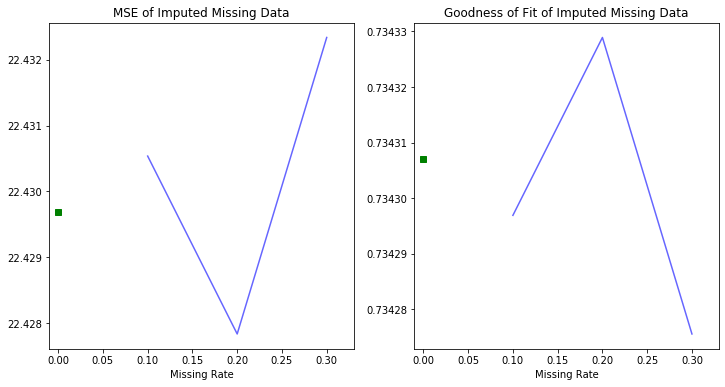

In [177]:
plt.figure(figsize=(12, 6))
ax3 = plt.subplot(121)
ax3.plot(imp_scores_arr2['Missing Rate'], imp_scores_arr2['MSE'], alpha=0.6, c='blue')
ax3.plot(0, base_mse, 'gs')
ax3.set_title('MSE of Imputed Missing Data')
ax3.set_xlim(left=-.01, right=imp_scores_arr2['Missing Rate'][2]* 1.1)
ax3.set_xlabel('Missing Rate')

ax4 = plt.subplot(122)
ax4.plot(imp_scores_arr2['Missing Rate'], imp_scores_arr2['R2'], alpha=0.6, c='blue')
ax4.plot(0,base_r2, 'gs')
ax4.set_title('Goodness of Fit of Imputed Missing Data')
ax4.set_xlim(left=-.01, right=imp_scores_arr2['Missing Rate'][2]* 1.1)
ax4.set_xlabel('Missing Rate')

plt.show()

### Step 4: MNAR Imputation Performance 
Create a Missing Not at Random pattern in which 25% of the data is missing for a single column. 

In [181]:
# To find what value the highest 25% of CRIM are (to know where to slice)
np.quantile(x[:,0],.75)

3.6770825

In [189]:
def mnar_dataset(x,rate = 0.25,random=0):
    rate = 1-rate
    # creates a boolean that looks for where the NO levels are greater than 85% of the maximum value of NO in the dataset
    x_check = np.where(x[:,0]>np.quantile(x[:,0],rate))
    X_missing = x.copy()
    X_missing[x_check, 0] = np.nan
    return X_missing

In [196]:
x_new = mnar_dataset(x)
x_impute = imputer.fit_transform(x_new)
mse_mnar, r2_mnar = regTesting(x_impute,y)


In [198]:
print('Baseline MSE:', base_mse,'\nBaseline R2:', base_r2)
print('\nMNAR Imputed MSE:', mse_mnar,'\nMNAR Imputed R2:', r2_mnar)

Baseline MSE: 22.429681439489926 
Baseline R2: 0.7343070437613076

MNAR Imputed MSE: 23.011198785250176 
MNAR Imputed R2: 0.7274186239183448
